
# Derivatives Pricing Project

This notebook implements and compares several classical methods for option pricing.  
The goal is not only to code the models, but also to understand their assumptions, strengths, and weaknesses — and to prepare for interviews on derivatives roles.

### Contents
- **A. Binomial Tree Model**: Pricing European and American options, comparison with closed-form.
- **B. Monte Carlo Simulation**: Pricing via risk-neutral path simulation, with variance reduction.
- **C. Black–Scholes Closed-Form**: European option pricing with greeks.
- **D.  Greeks Estimation**: Finite-difference vs closed-form comparisons.
- **E.Implied Volatility**: Root-finding methods (Brent, Newton, Bisection) and volatility smile construction.
- **F. American Options**: Early exercise feature, intuition and pricing.
- **G. Extensions**: Dividends, implied volatility surface, convergence analysis.


## Parameters Setup

In [20]:
S0 = 100
K = 100
r = 0.02
q = 0
sigma = 0.2
T = 1
steps = 50 
seed = 12345

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from deriv_pricing.payoff import call_payoff, put_payoff, put_call_parity_price

## Vanilla Payoff and Put-Call Parity

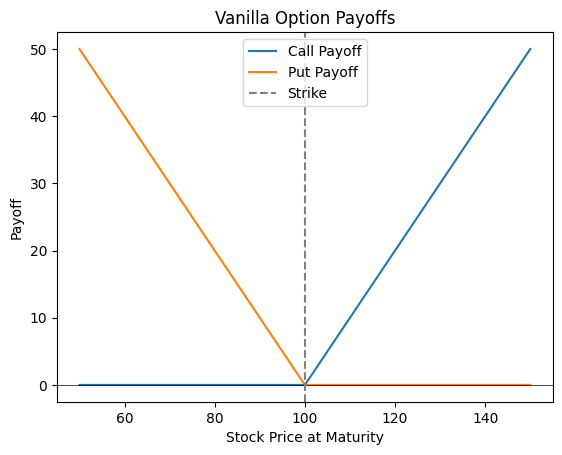

In [22]:
# Draw payoff diagram for put and call
S = np.linspace(50, 150, 200)

calls = call_payoff(S, K)
puts = put_payoff(S, K)

plt.plot(S, calls, label = 'Call Payoff')
plt.plot(S, puts, label = 'Put Payoff')
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(K, color="gray", linestyle="--", label="Strike")
plt.legend()
plt.xlabel("Stock Price at Maturity")
plt.ylabel("Payoff")
plt.title("Vanilla Option Payoffs")
plt.show()


## Binomial Tree Model

**What I did**:  
- Implemented CRR binomial tree for European and American options.  
- Verified convergence to Black–Scholes for European.  
- Demonstrated early exercise premium for American puts.

**Methodology**

- Tree dynamics: $u=e^{\sigma\sqrt{\Delta t}},\ d=\tfrac{1}{u},\ p=\tfrac{e^{(r-q)\Delta t}-d}{u-d}$
- Backward induction (American): $V_{i,j}=\max\{\text{exercise payoff},\ e^{-r\Delta t}\big(p\,V_{i+1,j+1}+(1-p)\,V_{i+1,j}\big)\}$
- Interview points:
  - Why binomial trees can handle American options.  
  - Convergence properties vs closed-form.  
  - Link to finite difference PDE methods.

In [23]:
from deriv_pricing.binomial import binomial_european_option

steps=[10, 50, 100, 500, 1000]
binomial_prices_call = []
binomial_prices_put = []
parity_put = []
col_name = ['Call Price', 'Put Price']

for i in steps: 
    c_price = binomial_european_option(S0, K, r, q, sigma, T, i)
    p_price = binomial_european_option(S0, K, r, q, sigma, T, i, option='put')
    parity_p_price = put_call_parity_price(c_price, S0, K, r, q, T)
    binomial_prices_call.append(c_price)
    binomial_prices_put.append(p_price)
    parity_put.append(parity_p_price)

# Compare prices based on different steps

binomial_tab = pd.DataFrame(
    {'Call Price': binomial_prices_call, 
     'Put Price': binomial_prices_put,
     'Put Price from Parity': parity_put}, 
    index=steps)
binomial_tab


,Call Price,Put Price,Put Price from Parity
10,8.720683,6.740550,6.740550
50,8.876513,6.896380,6.896380
100,8.896250,6.916117,6.916117
500,8.912076,6.931943,6.931943
1000,8.914056,6.933924,6.933924


/var/folders/zg/4k9h9dqx08q8fyj24lyqs5_40000gp/T/ipykernel_99422/3401342206.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/zg/4k9h9dqx08q8fyj24lyqs5_40000gp/T/ipykernel_99422/3401342206.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


Text(0.5, 1.0, 'Put Price')

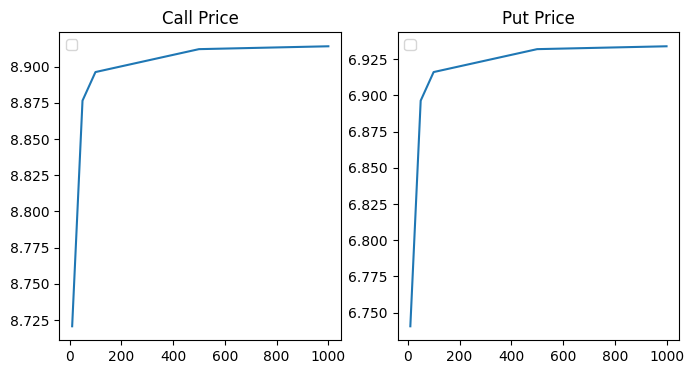

In [24]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(8,4))
ax1.plot(binomial_tab['Call Price'])
ax1.legend()
ax1.set_title("Call Price")
ax2.plot(binomial_tab['Put Price'])
ax2.legend()
ax2.set_title("Put Price")

In [25]:
from deriv_pricing.binomial import delta_binomial

strikes = [80, 100, 120]

binomials_deltas_call = {}
binomials_deltas_put = {}

for k in strikes:
    binomials_deltas_call[f'K={k}'] = [delta_binomial(S0, k, r, q, sigma, T, i, option = 'call') for i in steps]
    binomials_deltas_put[f'K={k}'] = [delta_binomial(S0, k, r, q, sigma, T, i, option = 'put') for i in steps]

bin_delta_call_df = pd.DataFrame(binomials_deltas_call, 
                                 index = [f'N={i}' for i in steps]
                                 )
print('Binomial Deltas for Calls')
bin_delta_call_df


Binomial Deltas for Calls


,K=80,K=100,K=120
N=10,0.875067,0.577332,0.228589
N=50,0.883098,0.578870,0.214979
N=100,0.903288,0.579064,0.242116
N=500,0.906273,0.579221,0.229934
N=1000,0.904368,0.579240,0.236682


In [26]:
bin_delta_put_df = pd.DataFrame(binomials_deltas_put, 
                                 index = [f'N={i}' for i in steps]
                                 )
print('Binomial Deltas for Puts')
bin_delta_put_df

Binomial Deltas for Puts


,K=80,K=100,K=120
N=10,-0.124933,-0.422668,-0.771411
N=50,-0.116902,-0.421130,-0.785021
N=100,-0.096712,-0.420936,-0.757884
N=500,-0.093727,-0.420779,-0.770066
N=1000,-0.095632,-0.420760,-0.763318


## Monte Carlo Simulation

**What I did**:  
- Simulated option payoffs using risk-neutral dynamics with/without antithetic variates.  
- Compared Monte Carlo estimate to Black–Scholes price.

**Methodology**:  
- Dynamics:
  $
  S_T = S_0 \exp\left((r-q-0.5\sigma^2)T + \sigma \sqrt{T} Z\right),\quad Z\sim N(0,1)
  $
- Discounted payoff average approximates option value.  
- Variance reduction: Antithetic sampling.  
- Interview points:
  - Convergence rate of Monte Carlo (O(1/√N)).  
  - When MC is preferred (path-dependent, exotic options).  
  - Variance reduction methods (antithetic, control variates).

In [8]:
from deriv_pricing.monte_carlo import mc_european_call

paths=[1e4, 5e4, 1e5, 5e5]
mc_baseline_c = []
mc_baseline_c_std = []
#mc_baseline_p = []

for path in paths:
    price = mc_european_call(S0, K, r, q, sigma, T, int(path), False, seed)[0]
    std = mc_european_call(S0, K, r, q, sigma, T, int(path), False, seed)[1]
    mc_baseline_c.append(price)
    mc_baseline_c_std.append(std)


mc_baseline_df = pd.DataFrame({
    'Standard MC value': mc_baseline_c,
    'Std of MC': mc_baseline_c_std
}, index=paths
)

mc_baseline_df

,Standard MC value,Std of MC
10000.0,8.928659,0.138744
50000.0,8.903301,0.061332
100000.0,8.964525,0.043684
500000.0,8.921713,0.019520


Text(0, 0.5, 'std')

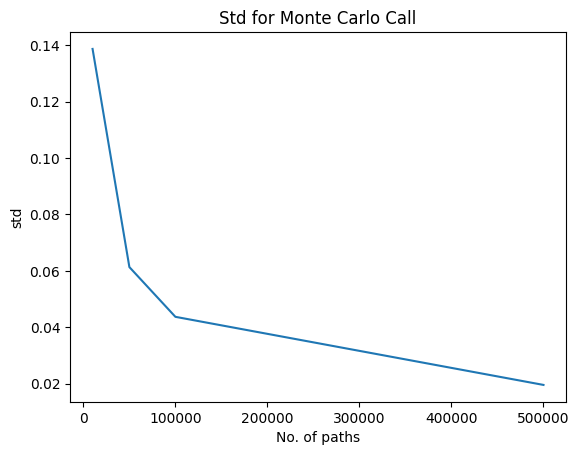

In [9]:
plt.plot(paths, mc_baseline_c_std)
plt.title('Std for Monte Carlo Call')
plt.xlabel('No. of paths')
plt.ylabel('std')

## Black–Scholes Closed-Form

**What I did**:  
- Implemented closed-form pricing for European calls/puts with continuous dividends.  
- Computed Greeks (Delta, Gamma, Vega) and compared to numerical approximations.

**Methodology**:  
- Model: Geometric Brownian Motion under risk-neutral measure.  
- Formula: 
  $
  C = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
  $
  and
  $
  d_1 = \frac{\ln(S_0/K)+(r-q+0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1-\sigma\sqrt{T}
  $
- Interview points:
  - Intuition behind risk-neutral measure.  
  - Put-Call Parity (with dividend adjustment).  
  - Why closed-form works only for European, not American.

In [10]:
S0 = 100
K = 100
r = 0.02
sigma = 0.2
T = 1
steps = 50 
#paths
seed = 12345

In [11]:
from deriv_pricing.black_scholes import bs_european_option

bs_price_call = bs_european_option(S0, K, r, q, sigma, T, 'call')
bs_price_put = bs_european_option(S0, K, r, q, sigma, T, 'put')

print(f'Black Scholes Price for call is {bs_price_call} and put under same conditions is {bs_price_put}')

Black Scholes Price for call is 8.916037278572539 and put under same conditions is 6.93590460924807


In [12]:
# Binomial(steps=1000) vs MC(1e5) vs BS
import time

t0 = time.time()
bin_1000_call = binomial_european_option(S0, K, r, q, sigma, T, steps=1000, option='call')
t1_bin = (time.time() - t0) * 1000

t0 = time.time()
MC_1e5_call, MC_se = mc_european_call(S0, K, r, q, sigma, T, n_paths=int(1e5), antithetic=False, seed=seed)
t1_mc = (time.time() - t0) * 1000

t0 = time.time()
bs_price_call = bs_european_option(S0, K, r, q, sigma, T, 'call')
t1_bs = (time.time() - t0) * 1000

rows = [
    {
        "Method": "Black–Scholes (Closed-form)",
        "Price": bs_price_call,
        "Std. Error": np.nan,
        "Runtime (ms)": t1_bs,
        "Abs Error vs BS": 0.0,
        "Rel Error vs BS": 0.0,
    },
    {
        "Method": "Monte-Carlo (paths = 1e5)",
        "Price": MC_1e5_call,
        "Std. Error": MC_se,
        "Runtime (ms)": t1_mc,
        "Abs Error vs BS": abs(MC_1e5_call - bs_price_call),
        "Rel Error vs BS": abs(MC_1e5_call - bs_price_call) / bs_price_call,
    },
    {
        "Method": "Binomial Tree (steps = 1000)",
        "Price": bin_1000_call,
        "Std. Error": np.nan,
        "Runtime (ms)": t1_bin,
        "Abs Error vs BS": abs(bin_1000_call - bs_price_call),
        "Rel Error vs BS": abs(bin_1000_call - bs_price_call) / bs_price_call,
    },
]

call_price_compare = pd.DataFrame(rows)
call_price_compare


,Method,Price,Std. Error,Runtime (ms),Abs Error vs BS,Rel Error vs BS
0,Black–Scholes (Closed-form),8.916037,NaN,2.434969,0.000000,0.000000
1,Monte-Carlo (paths = 1e5),8.964525,0.043684,14.013290,0.048488,0.005438
2,Binomial Tree (steps = 1000),8.914056,NaN,68.308115,0.001981,0.000222


## Greeks Estimation

**What I did**:  
- Compared closed-form Greeks with finite-difference approximations.  
- Discussed numerical error and step-size trade-offs.

**Methodology**:  
- Central difference for Delta, Gamma, Vega.  
- Error term O(h²).  
- Greeks are sensitivities → crucial for hedging.  
- Interview points:
  - How desks hedge Delta/Gamma/Vega.  
  - Why numerical estimation may deviate (finite diff error, Vega flatness in wings).  
  - Practical use: Greeks are risk metrics, not just math.

In [13]:
#Greeks
from deriv_pricing.greeks import delta_fd, gamma_fd, vega_fd
from deriv_pricing.black_scholes import bs_european_greeks

# Greeks from BS
bs_delta_call = bs_european_greeks(S0, K, r, q, sigma, T)[0]
bs_gamma_call = bs_european_greeks(S0, K, r, q, sigma, T)[1]
bs_vega_call = bs_european_greeks(S0, K, r, q, sigma, T)[2]



# Greeks from finite difference
h = 1e-4
delta_pricer = lambda s: bs_european_option(s, K, r, q, sigma, T)
fd_delta_call = delta_fd(delta_pricer, S0, h)
fd_gamma_call = gamma_fd(delta_pricer, S0, h)
vega_pricer = lambda sigma: bs_european_option(S0, K, r, q, sigma, T)
fd_vega_call = vega_fd(vega_pricer, sigma, h)

bs_greeks = bs_european_greeks(S0, K, r, q, sigma, T)

fd_greeks = [fd_delta_call, fd_gamma_call, fd_vega_call]

greeks_df = pd.DataFrame(
    {
        'Black-Scholes Greeks': bs_greeks,
        'Finite-Difference Greeks': fd_greeks
    },
    index = ['Delta', 'Gamma', 'Vega']
)

greeks_df




,Black-Scholes Greeks,Finite-Difference Greeks
Delta,0.579260,0.579260
Gamma,0.019552,0.019551
Vega,57.925971,39.104269


**Where does the divergence come from for gamma and vega?**
- Finite Difference Method's natural error term 
- Gamma measures convexity (2nd derivative), hence more sensitive to differences

## Implied Volatility

**What I did**:  
- Generated synthetic market prices and solved for implied volatility using Brent, Newton–Raphson, and Bisection.  
- Constructed a volatility smile.

**Methodology**:  
- Root-finding:
  Solve for σ such that BS(σ) = market price.  
- Numerical methods compared:
  - Brent (robust, bracketed).  
  - Bisection (safe but slow).  
  - Newton (fast but sensitive to initial guess, requires Vega).  
- Interview points:
  - Why implied volatility is central in practice.  
  - Volatility smile/surface and what it reflects (market frictions, fat tails, demand/supply).  
  - Strengths and weaknesses of each root-finder.

Root-Finding Algorithms
- Bisection (Slow, but stable, must converge)
- Newton-Raphson (Quick, but need first order derivative)
- Brent Method (Mixed of all above)

In [ ]:
from deriv_pricing.implied_vol import option_market_price, f_sigma, IV_brentq, IV_Bisect, IV_Newton

sigma_noise = 0.01
lo, hi = 1e-8, 10
x0 = 0.2
h_newton = 1e-6

V_mkt = option_market_price(S0, K, r, q, sigma, T, 'call', sigma_noise, seed)
lower = max(S0 * np.exp(-q*T) - K*np.exp(-r*T), 0.0)          # q=0 o/w: S0*e^{-qT}-K*e^{-rT}
upper = S0 * np.exp(-q*T)                                     # if div exists: S0*e^{-qT}
V_mkt = np.clip(V_mkt, lower, upper)
V_mkt = float(V_mkt)

iv_brent = IV_brentq(f_sigma, lo, hi, S0, K, r, q, T, V_mkt, 'call')

iv_newton= IV_Newton(x0, S0, K, r, q, T, V_mkt, 'call', h_newton)

iv_bisect = IV_Bisect(lo, hi, S0, K, r, q, T, V_mkt, 'call')

IV_ATM_call = pd.DataFrame(
    {'Brentq': iv_brent,
    'Newton': iv_newton,
    'Bisect': iv_bisect,
    'True Sigma': sigma}, 
    index = ['Implied Vol'],
)

IV_ATM_call


0.19675357707109914 0.19675357707129237 0.19675357707231655
               Brentq    Newton    Bisect  True Sigma
Implied Vol  0.196754  0.196754  0.196754         0.2


Text(0.5, 1.0, 'Implied Vol Smile')

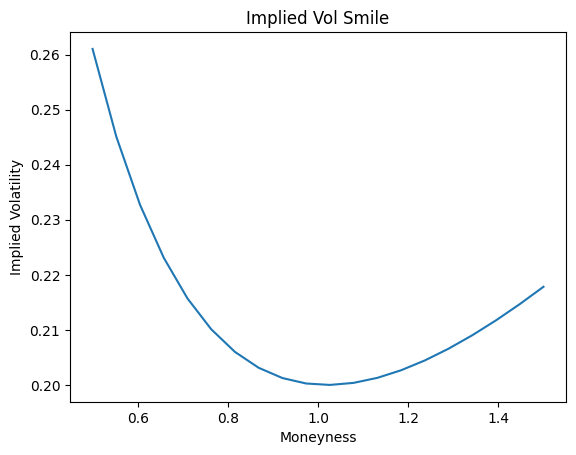

In [47]:
# Plot Smile 
# For each K, derive IV, plot IV against K/SO

q = 0

K_list = np.linspace(50, 150, 20)
Moneyness_list = [i / S0 for i in K_list]
IV_list = []    

def sigma_target(k, sigma0=0.20, alpha=0.6):
    return sigma0*(1.0 + alpha*k**2)

IV_true, IV_back = [], []

F = S0*np.exp((r-q)*T)

for strike in K_list:
    k = np.log(strike/F)
    sig = sigma_target(k)
    IV_true.append(sig)
    C_mkt = bs_european_option(S0, strike, r, q, sig, T, option="call")

    lower = max(S0*np.exp(-q*T) - strike*np.exp(-r*T), 0.0)
    upper = S0*np.exp(-q*T)
    if not (lower+1e-6 < C_mkt < upper-1e-6):
        IV_back.append(np.nan); continue

    iv = IV_brentq(f_sigma, lo, hi, S0, strike, r, q, T, C_mkt, 'call')
    IV_back.append(iv)

plt.plot(Moneyness_list, IV_back)
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Implied Vol Smile')





In [50]:
S0 = 100
K = 100
r = 0.02
q = 0
sigma = 0.2
T = 1
steps = 50 
seed = 12345

In [52]:
# Antithetic
mc_baseline_antithe = []
mc_baseline_c_antithe_std = []

for path in paths:
    price = mc_european_call(S0, K, r, q, sigma, T, int(path), True, seed)[0]
    std = mc_european_call(S0, K, r, q, sigma, T, int(path), True, seed)[1]
    mc_baseline_antithe.append(price)
    mc_baseline_c_antithe_std.append(std)

mc_vr_compare = pd.DataFrame({
    'Standard MC value': mc_baseline_c,
    'MC value with Antithetic': mc_baseline_antithe,
    'Std of Standard MC': mc_baseline_c_std,
    'Std with Antithetic': mc_baseline_c_antithe_std
}, index = paths
)

mc_vr_compare

,Standard MC value,MC value with Antithetic,Std of Standard MC,Std with Antithetic
10000.0,8.928659,8.991496,0.138744,0.140892
50000.0,8.903301,8.913864,0.061332,0.061841
100000.0,8.964525,8.868005,0.043684,0.043474
500000.0,8.921713,8.900601,0.019520,0.019494


In [53]:
# Control Variates
from deriv_pricing.monte_carlo import control_var

mc_baseline_controlvar = []
mc_baseline_controlvar_std = []

for path in paths:
    price, std = control_var(S0, K, r, q, sigma, T, int(path), seed)
    mc_baseline_controlvar.append(price)
    mc_baseline_controlvar_std.append(std)

control_var_df = pd.DataFrame({
    'MC Call with Control Variates': mc_baseline_controlvar,
    'Std with Control Variates': mc_baseline_controlvar_std,
}, index = paths)

control_var_df

,MC Call with Control Variates,Std with Control Variates
10000.0,8.928659,0.059702
50000.0,8.903301,0.026244
100000.0,8.964525,0.018585
500000.0,8.921713,0.008304


In [54]:
# Comparison of Standard MC, Antithetic, Control Variates
# Columns: Values x3, Variance x3

mc_vr_3 = pd.DataFrame({
    'Standard MC': mc_baseline_c,
    'MC with Antithetic': mc_baseline_antithe,
    'MC with Control Variates': mc_baseline_controlvar,
    'Std of Standard MC': mc_baseline_c_std,
    'Std of Antithetic': mc_baseline_c_antithe_std,
    'Std of Control Variates': mc_baseline_controlvar_std
}, index = paths)



mc_vr_3

,Standard MC,MC with Antithetic,MC with Control Variates,Std of Standard MC,Std of Antithetic,Std of Control Variates
10000.0,8.928659,8.991496,8.928659,0.138744,0.140892,0.059702
50000.0,8.903301,8.913864,8.903301,0.061332,0.061841,0.026244
100000.0,8.964525,8.868005,8.964525,0.043684,0.043474,0.018585
500000.0,8.921713,8.900601,8.921713,0.019520,0.019494,0.008304


In [55]:
for i in range(len(paths)):
    print(f"Variance reduction (control variates) for {int(paths[i])} paths: "
      f"{1 - mc_baseline_controlvar_std[i] / mc_baseline_c_std[i]:.6f}")


Variance reduction (control variates) for 10000 paths: 0.569696
Variance reduction (control variates) for 50000 paths: 0.572094
Variance reduction (control variates) for 100000 paths: 0.574554
Variance reduction (control variates) for 500000 paths: 0.574608


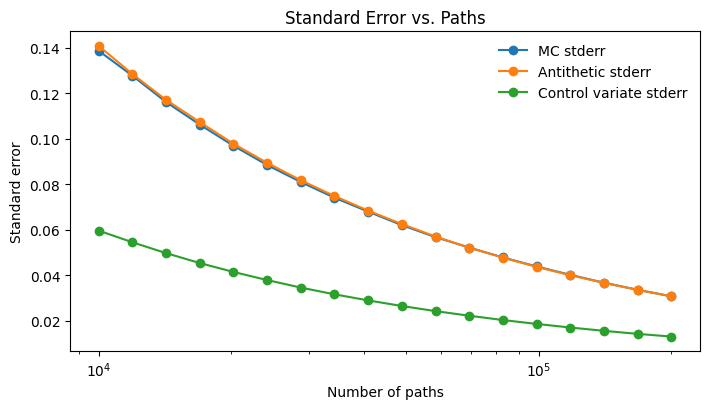

In [56]:
# Comparison of std

paths_grid = np.unique(np.geomspace(10_000, 200_000, 18).astype(int))

reps = 20 

mc_stderr, anti_stderr, cv_stderr = [], [], []
mc_val, cv_val = [], []

for n in paths_grid:
    mc_buf, mc_va, anti_buf, cv_buf, cv_va = [], [], [], [], []
    # Standard MC
    val_mc, se_mc   = mc_european_call(S0, K, r, q, sigma, T, int(n), False, seed)
    # Antithetic
    _, se_anti = mc_european_call(S0, K, r, q, sigma, T, n_paths=n, antithetic=True,  seed=seed)
    # Control Variates
    val_cv, se_cv   = control_var(S0, K, r, q, sigma, T, n_paths=n, seed=seed)

    mc_stderr.append(se_mc)
    anti_stderr.append(se_anti)
    cv_stderr.append(se_cv)

    mc_val.append(val_mc)
    cv_val.append(val_cv)

plt.figure(figsize=(7.2,4.2))
plt.plot(paths_grid, mc_stderr,   marker='o', label='MC stderr')
plt.plot(paths_grid, anti_stderr, marker='o', label='Antithetic stderr')
plt.plot(paths_grid, cv_stderr,   marker='o', label='Control variate stderr')
plt.xlabel('Number of paths')
plt.ylabel('Standard error')
plt.title('Standard Error vs. Paths')
plt.xscale('log')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()




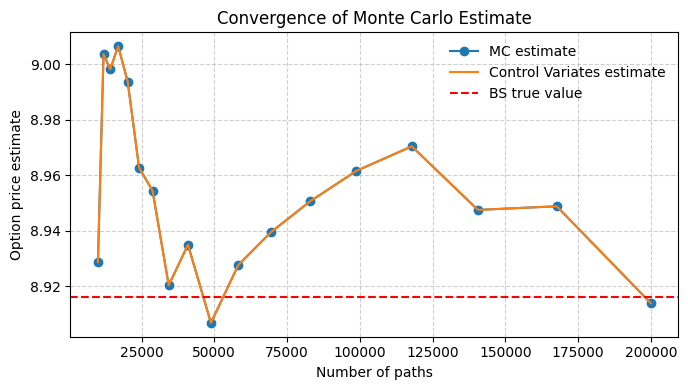

In [57]:
true_val = bs_price_call

plt.figure(figsize=(7,4))
plt.plot(paths_grid, mc_val, marker='o', label='MC estimate')
plt.plot(paths_grid, cv_val, label='Control Variates estimate')
plt.axhline(true_val, color='red', linestyle='--', label='BS true value')
plt.xlabel('Number of paths')
plt.ylabel('Option price estimate')
plt.title('Convergence of Monte Carlo Estimate')
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## American Options

**What I did**:  
- Implemented American put with binomial tree.  
- Showed American ≥ European (early exercise premium).  
- Discussed why American calls without dividends = European.

**Methodology**:  
- At each node:
  $
  V = \max(\text{exercise}, \text{hold})
  $
- Early exercise optimality depends on r, q, σ, T.  
- Interview points:
  - Why puts may be exercised early with positive r.  
  - Why calls only differ if dividends exist.  
  - Concept of early exercise boundary.

In [60]:
from deriv_pricing.binomial import binomial_american_option

amer_c_price = binomial_american_option(S0, K, r, q, sigma, T, steps, 'call')
amer_p_price = binomial_american_option(S0, K, r, q, sigma, T, steps, 'put')

print(f'American Call under the same parameters is: {amer_c_price} and put price is: {amer_p_price}')

American Call under the same parameters is: 8.876513135326693 and put price is: 7.087738876439911


In [ ]:
amer_call = []
amer_put = []
euro_call = []
euro_put = []

for k in strikes:
    amer_c_ = binomial_american_option(S0, k, r, q, sigma, T, steps, 'call')
    amer_p_ = binomial_american_option(S0, k, r, q, sigma, T, steps, 'put')
    euro_c_ = binomial_european_option(S0, k, r, q, sigma, T, steps, 'call')
    euro_p_ = binomial_european_option(S0, k, r, q, sigma, T, steps, 'put')
    
    amer_call.append(amer_c_)
    amer_put.append(amer_p_)
    euro_call.append(euro_c_)
    euro_put.append(euro_p_)

amer_cp_df = pd.DataFrame({
    'American Call': amer_call,
    'European Call': euro_call,
    'American Put': amer_put,
    'European Put': euro_put
}, index = [f'K={k}' for k in strikes]
)

amer_cp_df

,American Call,European Call,American Put,European Put
K=80,22.527836,22.527836,0.961477,0.943730
K=100,8.876513,8.876513,7.087739,6.896380
K=120,2.546228,2.546228,20.993248,20.170069


In [72]:
# Put

steps_list = [100, 200, 500, 1000]
amer_p_N, euro_p_N, premium_p_N = [], [], []

for N in steps_list:
    amer = binomial_american_option(S0, K, r, q, sigma, T, steps=N, option='put')        
    euro_tree = binomial_european_option(S0, K, r, q, sigma, T, steps=N, option='put')
    amer_p_N.append(amer)
    euro_p_N.append(euro_tree)
    premium_p_N.append(amer - euro_tree)

amer_euro_p_df = pd.DataFrame(
    {
        'American Put': amer_p_N,
        'European Put': euro_p_N,
        'Premium of American option': premium_p_N
    }, index = [f'N={n}' for n in steps_list]
)
     
amer_euro_p_df  



,American Put,European Put,Premium of American option
N=100,7.099470,6.916117,0.183353
N=200,7.105131,6.926004,0.179126
N=500,7.108559,6.931943,0.176616
N=1000,7.109691,6.933924,0.175768


---

## Possible Extensions (Future Work)

In order to bring this project closer to real-world derivatives practice, several extensions can be added:

### 1. Volatility Surface
- Extend the single-maturity volatility smile into a full volatility surface across strikes and maturities.  
- Method: generate synthetic option prices for different (K, T), invert implied volatilities, and plot in 3D.  
- Relevance: traders and structurers always look at surfaces (term structure + skew) rather than single smiles.

### 2. Hedging Simulation
- Implement a simple **delta-hedging strategy**:  
  - Hold a long call, short Δ shares, rebalance daily.  
  - Track hedged P&L over time vs unhedged.  
- Relevance: demonstrates how Greeks are used in practice for risk management, a key trading desk skill.

### 3. More Greeks
- Extend to Theta (time decay) and Rho (interest rate sensitivity).  
- Compare finite-difference vs closed-form formulas.  
- Relevance: interviewers often ask “what happens to option price if rates rise / time passes”.

### 4. Convergence Analysis
- Systematically compare:  
  - Binomial tree: price vs number of steps.  
  - Monte Carlo: price vs number of paths.  
- Plot error vs computational cost.  
- Relevance: highlights the trade-off between accuracy and efficiency in real implementations.

### 5. Exotic Options (prototype level)
- Add one example exotic, e.g.:
  - **Barrier option** (down-and-out call): closed-form exists, compare to MC.  
  - **Asian option** (average price): only MC feasible.  
- Relevance: shows readiness to handle non-vanilla products, common on trading desks.

### 6. Early Exercise Boundary
- For American options, compute the early exercise boundary curve over time.  
- Plot the critical stock price below which immediate exercise is optimal.  
- Relevance: demonstrates deeper understanding of the mechanics of American options.

---
